# HOMEWORK 5

In this homework you are going to implement the **Floyd-Steinberg dithering** algorithm. Dithering, in general, means that we are adding noise to the signal (in our case digital image) in order to perceive it better. In other words, by adding the noise the objective quality will be worse but the subjective quality will be better (i.e. the image will "look" better).

The details of FS dithering can be found in this [wiki](https://en.wikipedia.org/wiki/Floyd%E2%80%93Steinberg_dithering) page. In order to implement the dithering, we will implement the following steps:
* Define colour pallette
* Quantize the image to obtain the baseline and compute the average quantization error
* Implement FS dithering and compute the average quantization error

You will also have to answer the question at the end of this notebook.

Note: In this homework, you will have the chance to earn some extra points. See the "Bonus" section at the end of the notebook. Good luck!

As always, you are encouraged to use your own images :-)

In [1]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from tqdm import tqdm
plt.rcParams['figure.figsize'] = [15, 10]

Let's load the image.

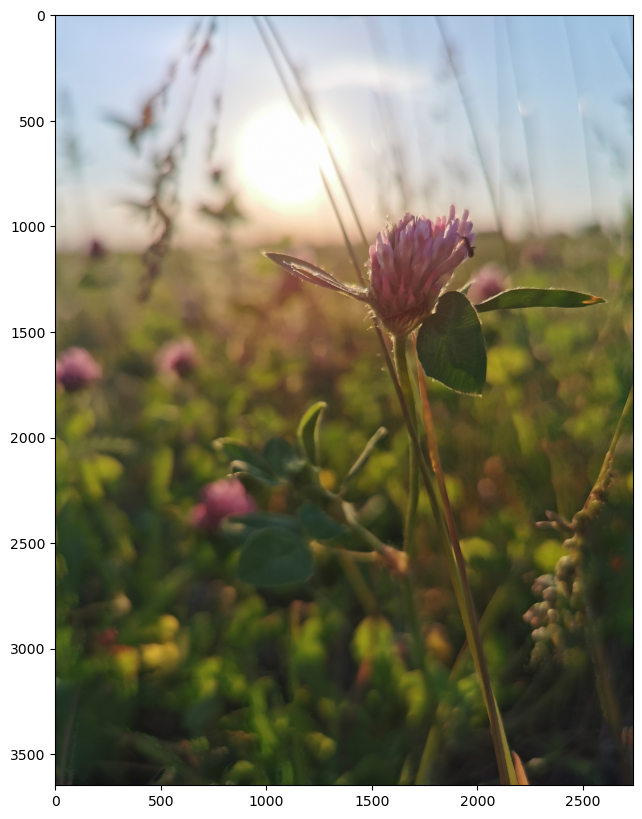

In [2]:
# Load image
img = cv2.imread('../data/IMG_20240524_194820.jpg')
# Convert it to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Plot it
plt.imshow(img)

Let's start with gray tones first.

In [3]:
# Black, dark gray, light gray, white
colors = np.array([[0, 0, 0],
                   [64, 64, 64],
                   [192, 192, 192],
                   [255, 255, 255]])
colors = colors / 255

Using the colour pallette, let's quantize the original image.

In [4]:
# Calculate Euclidean distance between 2 colors
def eu_dist(pixel_1, pixel_2):
    r_diff = pixel_1[0] - pixel_2[0]
    g_diff = pixel_1[1] - pixel_2[1]
    b_diff = pixel_1[2] - pixel_2[2]
    return math.sqrt(r_diff**2 + g_diff**2 + b_diff**2)

def quantize_pixel(pixel, color_palette):
    dist = 255 * 3
    closest_color = color_palette[0]
    
    for color in color_palette:
        new_dist = eu_dist(pixel, color)
        if new_dist < dist:
            dist = new_dist
            closest_color = color

    return closest_color

def opt_quant(img, color_palette):
    # Prepare for quantization
    rows, cols, channels = img.shape
    quantized = np.zeros_like(img)

    for r in tqdm(range(rows)):
        for c in range(cols):
            # Extract the original pixel value
            pixel = list(img[r, c, :])
            # Find the closest colour from the pallette (using absolute value/Euclidean distance)
            # Note: You may need more than one line of code here
            new_pixel = quantize_pixel(pixel, color_palette)
            # Apply quantization
            quantized[r, c, :] = new_pixel
            
    return quantized

def fs_dither(img, color_palette):
    # Prepare for quantization
    img_tmp = np.copy(img)
    rows, cols, channels = img_tmp.shape
    dithering = np.zeros_like(img)

    for r in tqdm(range(1, rows - 1)):
        for c in range(1, cols - 1):
            # Extract the original pixel value
            pixel = list(img_tmp[r, c, :])
            # Find the closest colour from the pallette (using absolute value/Euclidean distance)
            # Note: You may need more than one line of code here
            new_pixel = quantize_pixel(pixel, color_palette)
            # Compute quantization error
            quant_error = pixel - new_pixel
        
            # Diffuse the quantization error accroding to the FS diffusion matrix
            # Note: You may need more than one line of code here
            img_tmp[r, c+1, :] = img_tmp[r, c+1, :] + quant_error * 7 / 16
            img_tmp[r+1, c-1, :] = img_tmp[r+1, c-1, :] + quant_error * 3 / 16
            img_tmp[r+1, c, :] = img_tmp[r+1, c, :] + quant_error * 5 / 16
            img_tmp[r+1, c+1, :] = img_tmp[r+1, c+1, :] + quant_error * 1 / 16
        
            # Apply dithering
            dithering[r, c, :] = new_pixel

    return dithering

In [5]:
# Cast the image to float
img = img / 255

quantized = opt_quant(img, colors)

100%|██████████| 3648/3648 [01:13<00:00, 49.84it/s]


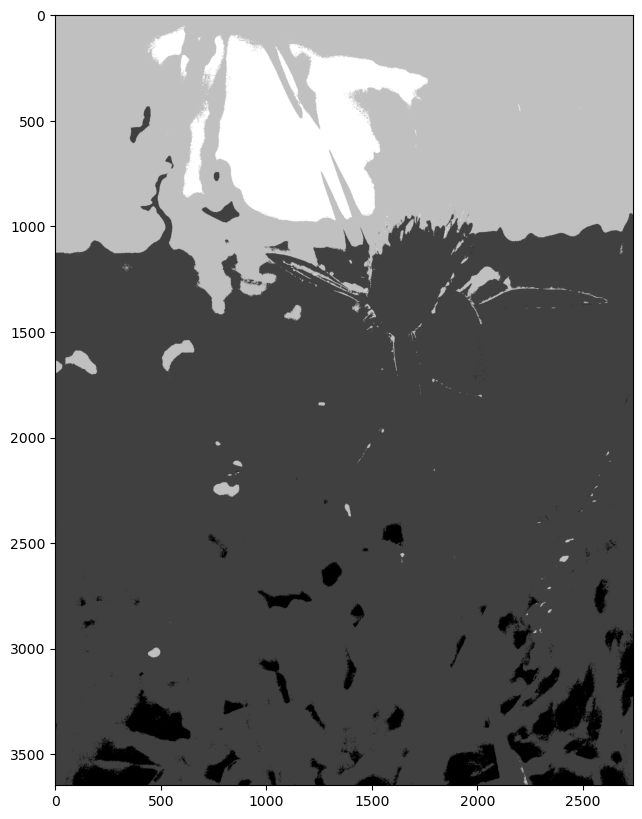

In [6]:
# Show quantized image (don't forget to cast back to uint8)
plt.imshow((quantized * 255).astype(np.uint8))

In [7]:
# Compute average quantization error
avg_quant_error = np.mean(np.square(img - quantized))
print(avg_quant_error)

0.014626866447603777


#### Floyd-Steinberg Dithering
We are now going to implement the FS dithering and compare it to the optimally quantized image we have calculated above.

In [8]:
dithering = fs_dither(img, colors)

100%|██████████| 3646/3646 [04:28<00:00, 13.59it/s]


(<Axes: >, <matplotlib.image.AxesImage at 0x2450646b4d0>)

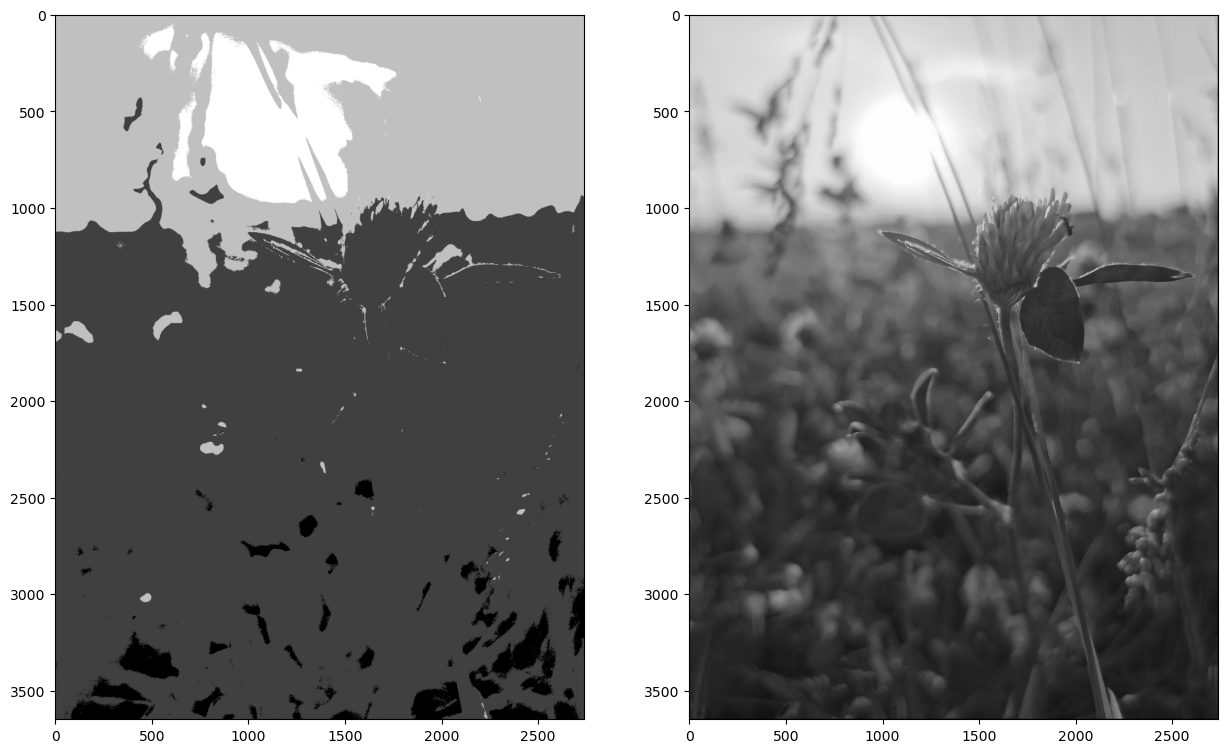

In [9]:
# Show quantized image (don't forget to cast back to uint8)
plt.subplot(121), plt.imshow((quantized * 255).astype(np.uint8))   # optimally quantized
plt.subplot(122), plt.imshow((dithering * 255).astype(np.uint8))   # dithering

In [10]:
# Compute average quantization error for dithered image
avg_dith_error = np.mean(np.square(img - dithering))
print(avg_dith_error)

0.025248080089005746


### Questions
* Which image has higher quantization error? Optimally quantized or dithered? \
  Dithered image has higher quantization error
* Which image looks better to you? \
  Dithered image looks much better
* Can you repeat the same process using only two colours: black and white? Show me :-) \
  Sure

In [11]:
colors_bw = np.array([[0, 0, 0],
                      [1, 1, 1]])
quantized_bw = opt_quant(img, colors_bw)
dithering_bw = fs_dither(img, colors_bw)

100%|██████████| 3646/3646 [04:11<00:00, 14.48it/s]


(<Axes: >, <matplotlib.image.AxesImage at 0x24500064110>)

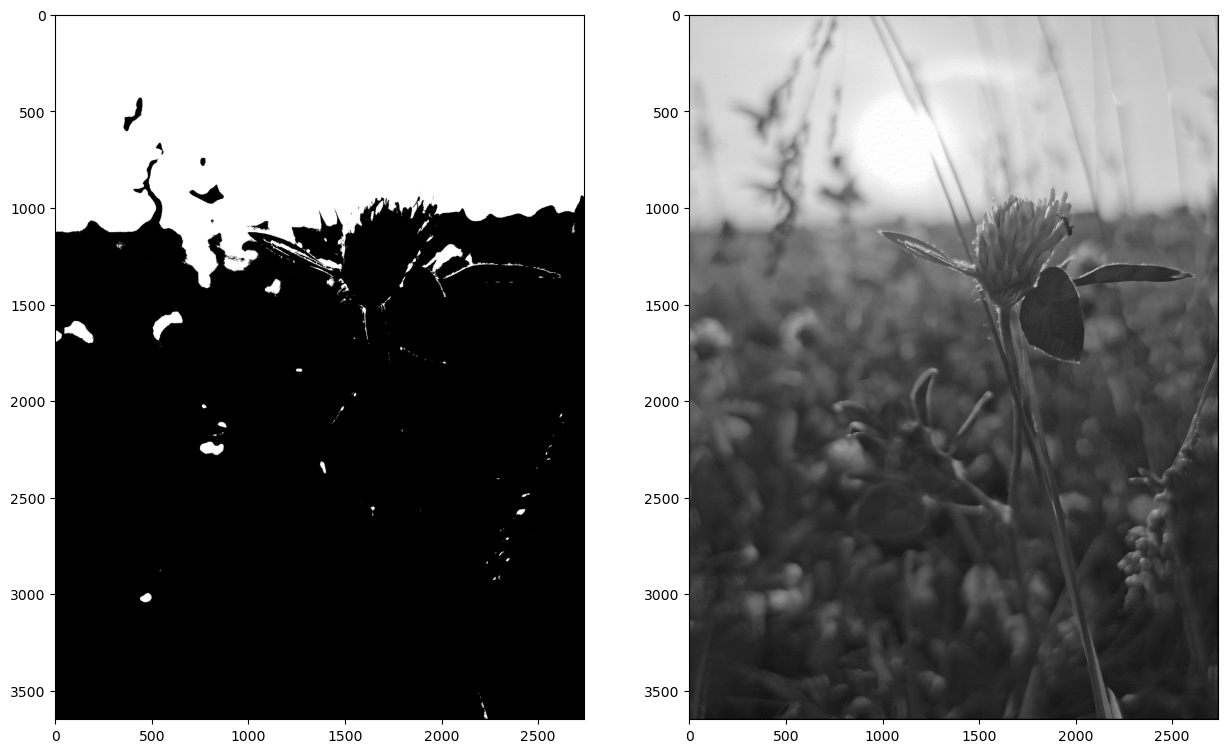

In [12]:
plt.subplot(121), plt.imshow((quantized_bw * 255).astype(np.uint8))   # optimally quantized
plt.subplot(122), plt.imshow((dithering_bw * 255).astype(np.uint8))   # dithering

### Bonus Points

Repeat the homework using a diffrerent image pallette. For instance, you can use an optimal colour
pallette that we can calculate via k-means algorithm. The following snippet of code will give you the 16
optimal colours for your original image.

In [13]:
kmeans = KMeans(n_clusters=16).fit(np.reshape(img, (-1, 3)))
colors_km_16 = kmeans.cluster_centers_

In [14]:
quantized_km_16 = opt_quant(img, colors_km_16)
dithering_km_16 = fs_dither(img, colors_km_16)

100%|██████████| 3646/3646 [07:08<00:00,  8.50it/s]


(<Axes: >, <matplotlib.image.AxesImage at 0x2457f16c750>)

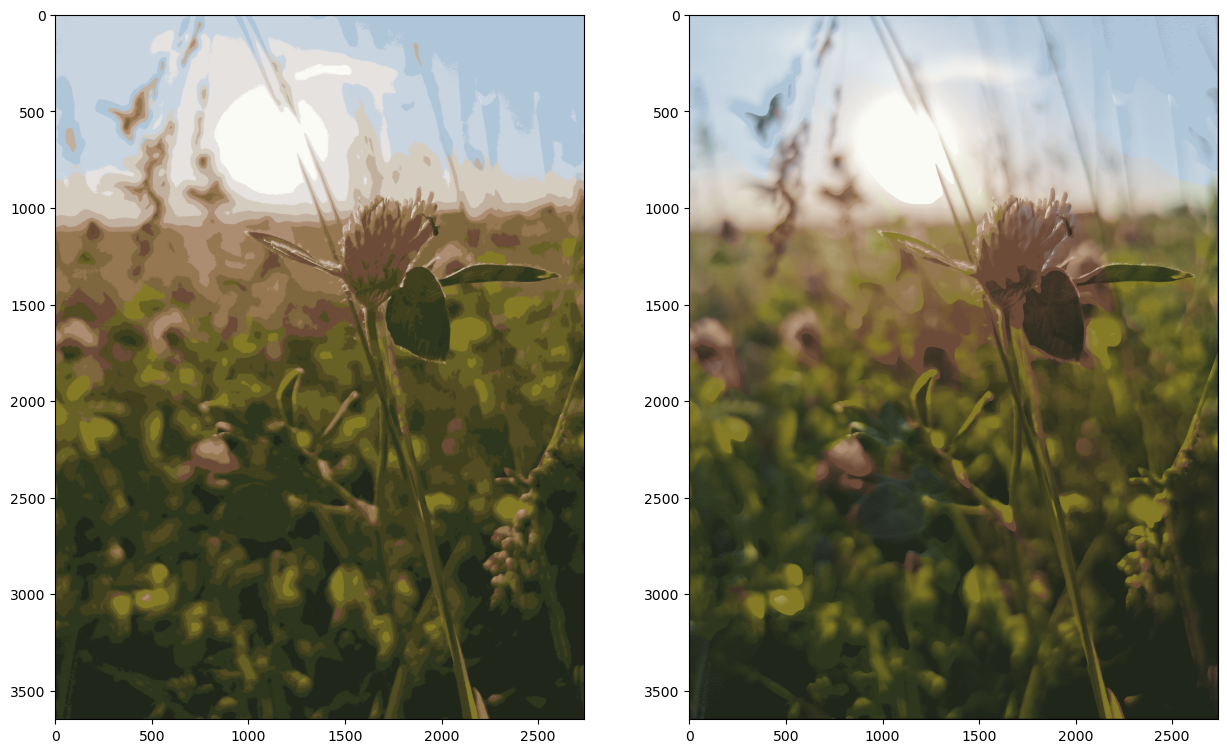

In [15]:
plt.subplot(121), plt.imshow((quantized_km_16 * 255).astype(np.uint8))   # optimally quantized
plt.subplot(122), plt.imshow((dithering_km_16 * 255).astype(np.uint8))   # dithering

Apply FS dithering the same way you did before.
* How does the result look like to you? \
  I can see that colors are unnatural due to small color palette and image lost details. But after dithering it looks bit better
* What happens if we use 32 colours? \
  When palette with 32 colors is used, colors look much more natural but some artifacts still persist (look at the leaves near the flower)
* And what happens if we use 256 colours? \
  With 256 colors palette image with dithering looks undistinguishable from original

In [16]:
kmeans = KMeans(n_clusters=32).fit(np.reshape(img, (-1, 3)))
colors_km_32 = kmeans.cluster_centers_

In [17]:
quantized_km_32 = opt_quant(img, colors_km_32)
dithering_km_32 = fs_dither(img, colors_km_32)

100%|██████████| 3646/3646 [11:06<00:00,  5.47it/s]


(<Axes: >, <matplotlib.image.AxesImage at 0x245000aae50>)

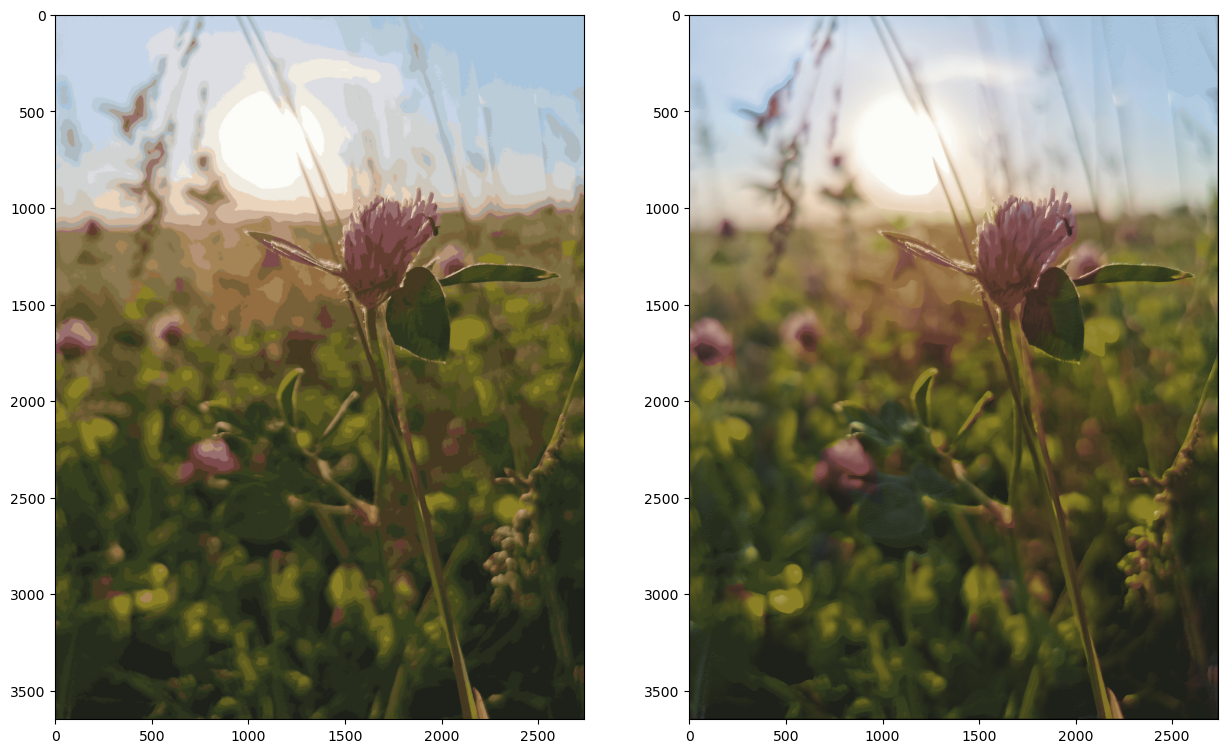

In [18]:
plt.subplot(121), plt.imshow((quantized_km_32 * 255).astype(np.uint8))   # optimally quantized
plt.subplot(122), plt.imshow((dithering_km_32 * 255).astype(np.uint8))   # dithering

In [19]:
kmeans = KMeans(n_clusters=256).fit(np.reshape(img, (-1, 3)))
colors_km_256 = kmeans.cluster_centers_

In [20]:
quantized_km_256 = opt_quant(img, colors_km_256)
dithering_km_256 = fs_dither(img, colors_km_256)

100%|██████████| 3646/3646 [52:36<00:00,  1.16it/s] 


(<Axes: >, <matplotlib.image.AxesImage at 0x24500506250>)

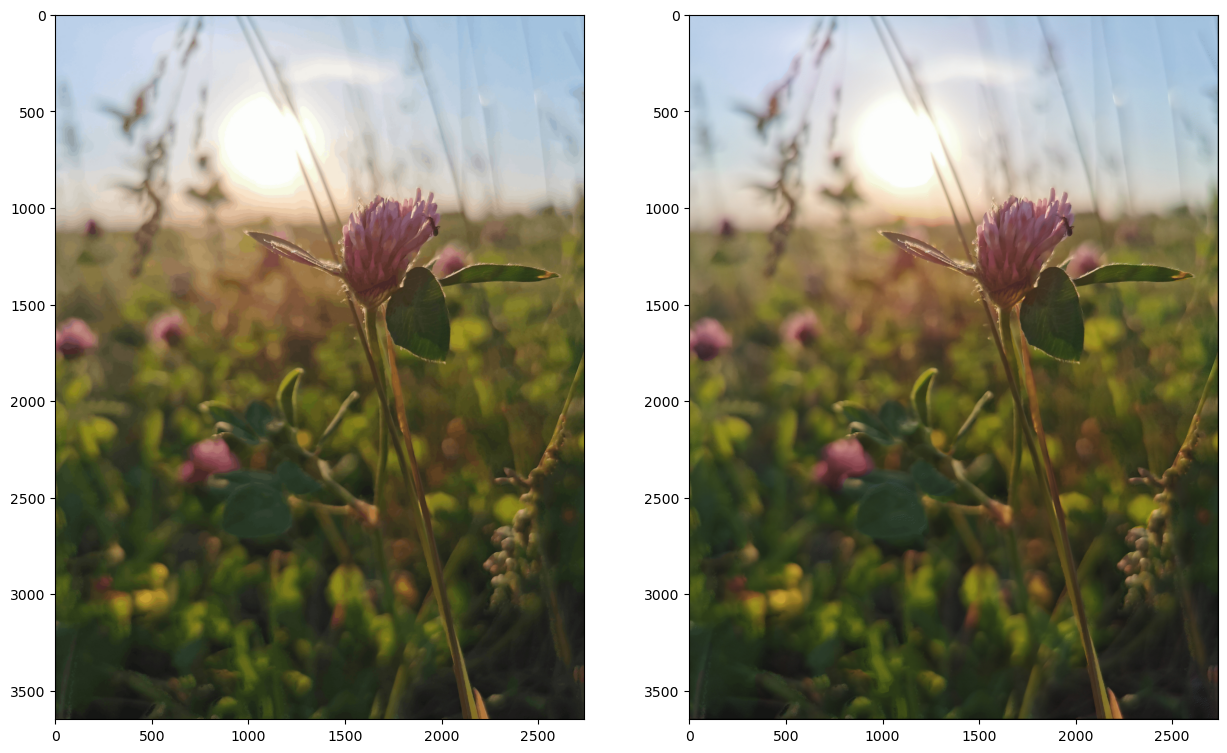

In [21]:
plt.subplot(121), plt.imshow((quantized_km_256 * 255).astype(np.uint8))   # optimally quantized
plt.subplot(122), plt.imshow((dithering_km_256 * 255).astype(np.uint8))   # dithering